In [45]:
# from torch.utils.data import Dataset, DataLoader
# # import YelpReviewPoplarity from torch
# from torch.utils.data.dataset import Dataset
# from torch.utils.data.dataloader import DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler
# from torch.utils.data.dataset import Dataset
# from torchtext.datasets import YelpReviewPolarity

In [2]:
import pandas as pd
import numpy as np
# read the csv file
df = pd.read_csv('df_sample.csv')

In [3]:
df

,Unnamed: 0,meeting_text,file_name,date
0,749,"Ladies and gentlemen. Good afternoon. Welcome,...",20190424_AXA_SA-_Shareholder_Mtg_Call_2019-4-2...,2019-04-24
1,1492,Greetings. Welcome to the Markel Corporation F...,20120510_Markel_Corp-_Earnings_Call_2012-5-10_...,2012-05-10
2,446,Good morning or good afternoon. Welcome to Swi...,20190731_Swiss_Re_AG-_Earnings_Call_2019-7-31_...,2019-07-31
3,1438,"Market Cap: 69,035.17. Current PX: 148.33. YTD...",20170726_Chubb_Ltd-_Earnings_Call_2017-7-26_FS...,2017-07-26
4,337,"Yasuyoshi Karasawa. Good afternoon, ladies and...",20190524_MS-AD_INSURANCE-_Guidance_Call_2019-5...,2019-05-24
...,...,...,...,...
913,423,"Ladies and gentlemen, good morning or good aft...",20160429_Swiss_Re_AG-_Earnings_Call_2016-4-29_...,2016-04-29
914,96,"Welcome, everyone, to our presentation today. ...",20200526_Aviva_PLC-_Shareholder_Mtg_Call_2020-...,2020-05-26
915,40,"Operator. (Operator Instructions) Good day, la...",20191204_Sanlam_Ltd-_Sales_Results_Call_2019-1...,2019-12-04
916,605,"Greetings, and welcome to the Lancashire Holdi...",20150729_LANCASHIRE_HOLDI-_Earnings_Call_2015-...,2015-07-29


In [5]:
import os
# import torch
# from tqdm import tqdm
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader,Dataset # 可以繼承 類似map and unmap
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer,BertModel,get_linear_schedule_with_warmup 
import seaborn as sns
# import nlpaug.augmenter.sentence as nas
# import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw

In [6]:
def preprocess(text):
  pattern = re.compile(r'\s+')
  text=text.replace('\u202f',' ').replace('xa0',' ')
  text=re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
  text=re.sub(r"\\u00b4",r'',text)
  text=re.sub(pattern, ' ', text)
  text = text.replace('?', ' ? ').replace(')', ') ').strip()
  return text

df['meeting_text']=df['meeting_text'].apply(preprocess)

In [25]:
# df.to_csv('df_sample_preprocess.csv',index=False)
df = pd.read_csv('df_sample_preprocessed.csv')
df

,Unnamed: 0,meeting_text,file_name,date
0,749,Ladies and gentlemen Good afternoon Welcome de...,20190424_AXA_SA-_Shareholder_Mtg_Call_2019-4-2...,2019-04-24
1,1492,Greetings Welcome to the Markel Corporation Fi...,20120510_Markel_Corp-_Earnings_Call_2012-5-10_...,2012-05-10
2,446,Good morning or good afternoon Welcome to Swis...,20190731_Swiss_Re_AG-_Earnings_Call_2019-7-31_...,2019-07-31
3,1438,Market Cap 6903517 Current PX 14833 YTD Change...,20170726_Chubb_Ltd-_Earnings_Call_2017-7-26_FS...,2017-07-26
4,337,Yasuyoshi Karasawa Good afternoon ladies and g...,20190524_MS-AD_INSURANCE-_Guidance_Call_2019-5...,2019-05-24
...,...,...,...,...
913,423,Ladies and gentlemen good morning or good afte...,20160429_Swiss_Re_AG-_Earnings_Call_2016-4-29_...,2016-04-29
914,96,Welcome everyone to our presentation today Tha...,20200526_Aviva_PLC-_Shareholder_Mtg_Call_2020-...,2020-05-26
915,40,Operator Operator Instructions Good day ladies...,20191204_Sanlam_Ltd-_Sales_Results_Call_2019-1...,2019-12-04
916,605,Greetings and welcome to the Lancashire Holdin...,20150729_LANCASHIRE_HOLDI-_Earnings_Call_2015-...,2015-07-29


In [26]:
df = df.iloc[0:100,:]
df

,Unnamed: 0,meeting_text,file_name,date
0,749,Ladies and gentlemen Good afternoon Welcome de...,20190424_AXA_SA-_Shareholder_Mtg_Call_2019-4-2...,2019-04-24
1,1492,Greetings Welcome to the Markel Corporation Fi...,20120510_Markel_Corp-_Earnings_Call_2012-5-10_...,2012-05-10
2,446,Good morning or good afternoon Welcome to Swis...,20190731_Swiss_Re_AG-_Earnings_Call_2019-7-31_...,2019-07-31
3,1438,Market Cap 6903517 Current PX 14833 YTD Change...,20170726_Chubb_Ltd-_Earnings_Call_2017-7-26_FS...,2017-07-26
4,337,Yasuyoshi Karasawa Good afternoon ladies and g...,20190524_MS-AD_INSURANCE-_Guidance_Call_2019-5...,2019-05-24
...,...,...,...,...
95,330,Good afternoon ladies and gentlemen Thank you ...,20140527_Sompo_Holdings_Inc-_Earnings_Call_201...,2014-05-27
96,1015,Philipp Gmuer Ladies and gentlemen I would lik...,20170313_Helvetia_Holding_AG-_Earnings_Call_20...,2017-03-13
97,601,Good morning and welcome to our Results Presen...,20160204_Beazley_PLC-_Earnings_Call_2016-2-4_F...,2016-02-04
98,193,Well good morning and welcome I think I know m...,20150811_Prudential_PLC-_Earnings_Call_2015-8-...,2015-08-11


In [27]:
# import the package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import re
import seaborn as sns
# import packages
from sklearn.linear_model import LogisticRegression
# from spellchecker import SpellChecker
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
# import en_core_web_sm
import spacy 
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
from tracemalloc import stop
from langcodes import best_match
from matplotlib import rc
import tomotopy as tp
from gensim.models import Phrases
import en_core_web_sm
nlp = en_core_web_sm.load()
import pickle # for spelling chcker

from rich.console import Console
from rich.table import Table

In [31]:
reviews = df['meeting_text']

In [32]:
# define a data cleaning function
def clean_data(reviews):
    # # step 1: separate x and y
    # convert review_text df to list
    reviews = reviews.to_list()
    
    # step 2: nromalize the review
    print(f"Total voc number: {len(reviews)}")
    reviews = list(map(lambda x: x.lower(),reviews))

    # step 3: remove Unicode Characters (punctuation, emoji,rul and @) 
    reviews = list(map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x),reviews))

    # step 4: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    reviews=list(map(lambda x: remove_whitespace(x),reviews))
                                                                                                                                                                                                                                                                                                    
    # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    
    # expand the list of stopwords
    gist_file = open("/Users/timliu/Documents/GitHub/final_01/gist_stopwords.txt", "r") # /Users/user/Documents/GitHub/data_collecting/testing/dataset/gist_stopwords.txt
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
      
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
      nlp.Defaults.stop_words.add(i)

    review  = pd.DataFrame({'text':reviews})

    def tokenized_reviews(text):
        return [str(token) for token in nlp(text) 
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]

    def tag_reviews(text):
        tags = ['NOUN','ADJ','VERB','ADV']
        return [token.pos_ for token in nlp(text) 
                if not token.is_stop 
                and not token.like_num
                and not token.is_punct
                and token.is_alpha
                # and token.pos_ in tags 
                ]

    review['tokens'] = review['text'].apply(tokenized_reviews)
    review['tags'] = review['text'].apply(tag_reviews)

    return review

In [33]:
# separate x and y
clean_text = clean_data(reviews)
clean_text

Total voc number: 100


,text,tokens,tags
0,ladies and gentlemen good afternoon welcome de...,"[ladies, gentlemen, good, afternoon, dear, sha...","[NOUN, NOUN, ADJ, NOUN, ADJ, NOUN, ADJ, NOUN, ..."
1,greetings welcome to the markel corporation fi...,"[markel, corporation, quarter, earnings, time,...","[NOUN, NOUN, NOUN, NOUN, NOUN, NOUN, ADJ, NOUN..."
2,good morning or good afternoon welcome to swis...,"[good, morning, good, afternoon, swiss, res, h...","[ADJ, NOUN, ADJ, NOUN, PROPN, PROPN, PROPN, NO..."
3,market cap 6903517 current px 14833 ytd change...,"[market, cap, current, px, ytd, change, ytd, c...","[NOUN, NOUN, NOUN, PROPN, PROPN, VERB, PROPN, ..."
4,yasuyoshi karasawa good afternoon ladies and g...,"[yasuyoshi, karasawa, good, afternoon, ladies,...","[PROPN, PROPN, ADJ, NOUN, NOUN, NOUN, NOUN, NO..."
...,...,...,...
95,good afternoon ladies and gentlemen thank you ...,"[good, afternoon, ladies, gentlemen, coming, b...","[ADJ, NOUN, NOUN, NOUN, VERB, VERB, NOUN, NOUN..."
96,philipp gmuer ladies and gentlemen i would lik...,"[philipp, gmuer, ladies, gentlemen, yearly, an...","[PROPN, PROPN, NOUN, NOUN, ADJ, NOUN, NOUN, NO..."
97,good morning and welcome to our results presen...,"[good, morning, presentation, year, ended, dec...","[ADJ, NOUN, NOUN, NOUN, VERB, PROPN, NOUN, NOU..."
98,well good morning and welcome i think i know m...,"[good, morning, mike, wells, group, chief, exe...","[ADJ, NOUN, PROPN, PROPN, NOUN, NOUN, NOUN, PR..."


In [38]:
# get the token
def remove_brackets(text):
    text = text.replace('[','')
    text = text.replace(']','')
    text = text.replace("'","")
    text = text.split(', ')
    return text

# use apply lambda to apply the function to df_train_clean['tokens']
temp_token = clean_text['tokens'].apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
# docs_tokens

AttributeError: 'list' object has no attribute 'replace'

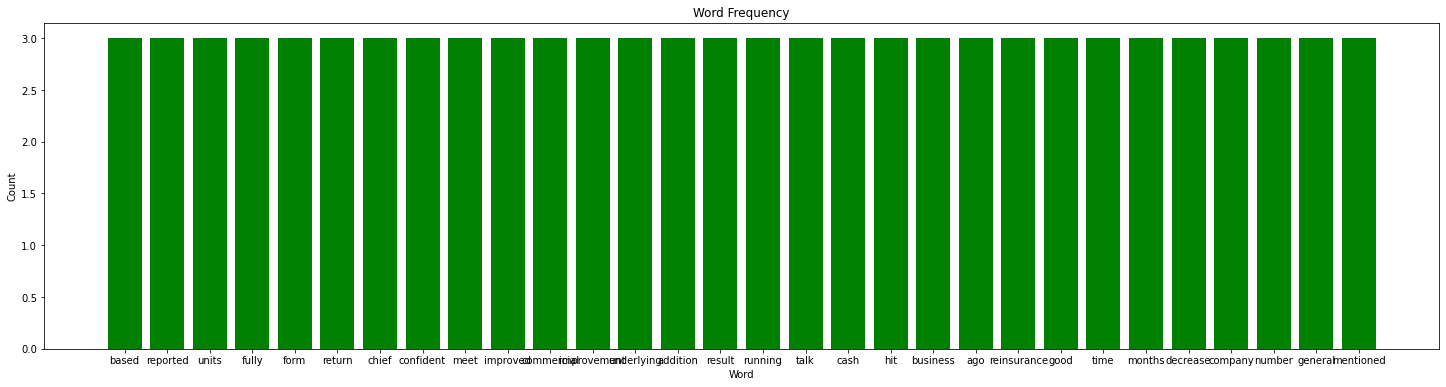

,word,freq
0,based,3
109,reported,3
102,units,3
103,fully,3
104,form,3
...,...,...
1103,agenda,1
1101,times,1
1100,determine,1
1099,aims,1


In [36]:
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(25, 6))
plt.bar(word_fr.word[0:30], word_fr.freq[0:30], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()
word_fr

In [37]:
# remove most frequent words which is known in this context
word_list = word_fr.head(3)['word'].to_list()
mdy_train, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_train.append(tmp)
    tmp=[]

clean_text['tokens'] = mdy_train
clean_text


ValueError: Length of values (3) does not match length of index (100)

In [ ]:
# save the clean_text
clean_text.to_csv('clean_text.csv', index=False)
# load the data 
clean_text = pd.read_csv('clean_text.csv')


TP

In [ ]:
# topic modeling
# # 使用“短語”方法，我們訓練一個捕獲二元組的模型（參見步驟 1）和一個捕獲三元組的模型（參見步驟 2）。
# common_terms = [
# u"of",u"with",u"without",u"and",u"or",u"the",
# u"a",u"not",u"be",u"to",u"this",u"who",u"in",
# ]

bigram = Phrases(                              # step 1 
    docs_tokens,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    # common_terms=common_terms,
)
trigram = Phrases(                             # step 2
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    # common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
# 借助這兩個模型，我們可以處理標記化的文檔並加入與二元組或三元組相關的標記。
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
# docs_phrased

In [ ]:
# set the random seed to make the results reproducible
np.random.seed(0)

# 我們相信這些文檔足夠乾淨，可以訓練主題建模。
# 使用 Tomotopy，有必要將預處理的文檔包裝在語料庫類對像中，
# 該對象必須被初始化（步驟 1）和填充（步驟 2）。
corpus = tp.utils.Corpus()                   # step 1 
for item in docs_phrased:                    # step 2 這邊輸入我們的文檔
    corpus.add_doc(words=item)

# 題建模過程的一個組成部分是探索替代模型的擬合，即保留不同數量主題的模型。
# 在此示例中，模型根據“u_ma​​ss”版本根據 Coherence Score 指標進行評估（分數越低，模型擬合越好）。
# 在第 1 步中，我們創建一個空字典來存儲不同模型的分數。
# 在第 2 步中，我們讓保留主題的數量在模型之間發生變化，並且對於每個模型，我們記錄相關的 Coherence Score
cvs = {}                                    # step 1
for topic_number in range(1, 31, 1):        # step 2
    mdl = tp.LDAModel(k=topic_number, corpus=corpus) # 這邊輸入我們的文檔
    for i in range(0, 100, 10): # 100 次迭代
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # 分數越低，模型擬合越好

# coherence of the results how to fix???????

# 這邊把csv視覺話 找最低分的
# The below chart displays the fit of the fifteen competing models, 
# retaining between one and fifteen topics.
# 下面的圖表顯示了 15 個競爭模型的擬合，保留 1 到 15 個主題。
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 31, 1))
plt.show()

# 圖表的可視檢查表示最佳模型是有 11 個主題的模型。
# 然而，為了提供更好的選擇，應該考慮更多的模型（例如在 1 到 200 主題的模型）。

In [ ]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=13, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt #.head(1).T

In [ ]:
# The second outcome of topic modeling we retrieve consists of the topic-to-document probabilities,
#  which we retrieve using the ‘get_topic_dist’ attribute, 
# available for any document included in the LDA corpus used for the training.
# 第二個主題建模的結果是主題到文件概率的預測，
# 這可以使用“get_topic_dist”屬性，可用於訓練 LDA 的資料庫中包含的任何文件。
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

In [ ]:
paragraph_split_df['tokens'] = clean_text['tokens']
paragraph_split_df['tags'] = clean_text['tags']
paragraph_split_df = pd.concat([paragraph_split_df, td], axis=1)
paragraph_split_df 
# internal and external participants put it in, add the frequency (single meeting, by the internal and external participants splitting )
# sentiment_score weight by the length of sentnece